In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

m, n = 10, 6
A = np.random.randn(m, n)
U, s, Vt = np.linalg.svd(A)

Sigma = np.zeros((m, n))
Sigma[:n, :n] = np.diag(s)
A_reconstructed = U @ Sigma @ Vt
error = np.linalg.norm(A - A_reconstructed, ord='fro')

print(f"Reconstruction Error (Frobenius Norm): {error:.2e}")

Reconstruction Error (Frobenius Norm): 7.72e-15


k values: [0 1 2 3 4 5 6]
Errors E(k): [np.float64(7.080558682162791), np.float64(5.4395641221674635), np.float64(3.950721590652471), np.float64(2.863629472914547), np.float64(2.1442274570728963), np.float64(1.4378450570587908), np.float64(7.71753812063122e-15)]


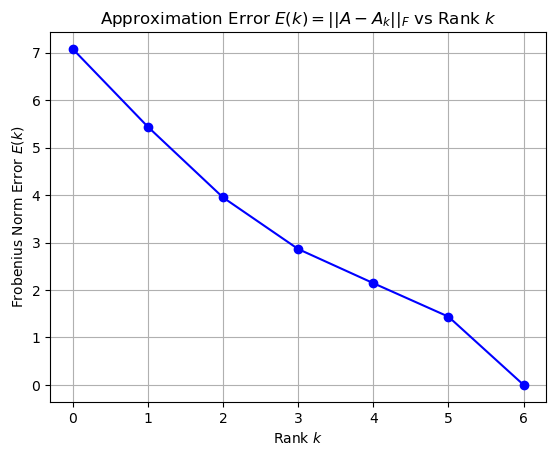

In [2]:
def rank_k_approx(U, s, Vt, k):
    Ak = U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]
    return Ak

k_values = np.arange(0, n + 1)
errors = []

for k in k_values:
    Ak = rank_k_approx(U, s, Vt, k)
    error = np.linalg.norm(A - Ak, 'fro')
    errors.append(error)

# Print results
print(f"k values: {k_values}")
print(f"Errors E(k): {errors}")

# 4. Plot the approximation error E(k) vs k
plt.plot(k_values, errors, marker='o', linestyle='-', color='b')
plt.title('Approximation Error $E(k) = ||A - A_k||_F$ vs Rank $k$')
plt.xlabel('Rank $k$')
plt.ylabel('Frobenius Norm Error $E(k)$')
plt.grid(True)

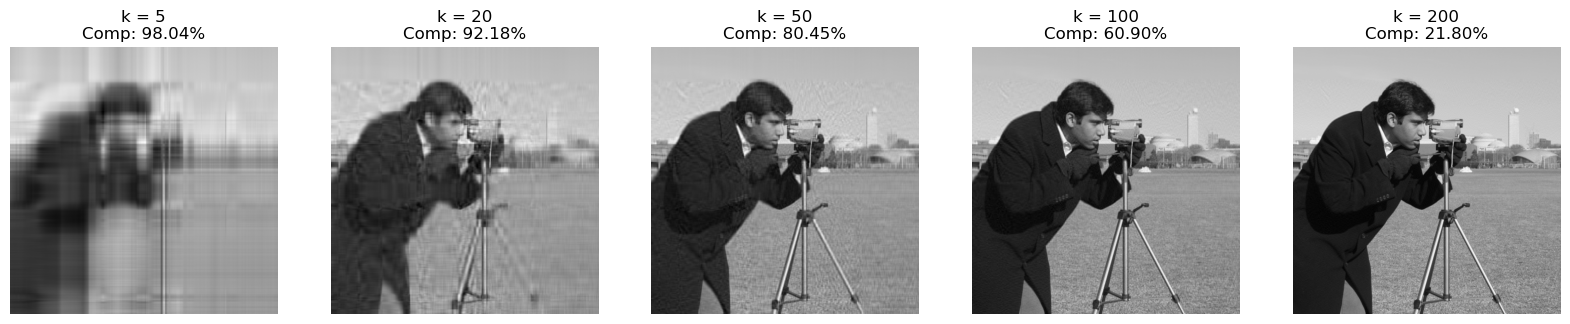

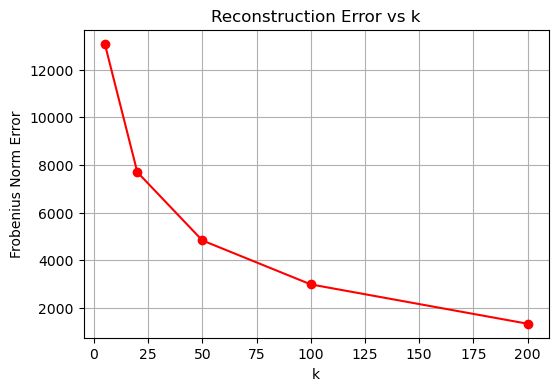

In [3]:
import skimage.data

X = skimage.data.camera().astype(float)
m, n = X.shape

U, s, Vt = np.linalg.svd(X, full_matrices=False)

ks = [5, 20, 50, 100, 200]

fig, axes = plt.subplots(1, len(ks), figsize=(20, 5))
errors = []
compressions = []

for i, k in enumerate(ks):
    Xk = (U[:, :k] * s[:k]) @ Vt[:k, :]
    
    c_k = 1 - (k * (m + n + 1)) / (m * n)
    compressions.append(c_k)
    
    err = np.linalg.norm(X - Xk, 'fro')
    errors.append(err)
    
    axes[i].imshow(Xk, cmap='gray')
    axes[i].set_title(f"k = {k}\nComp: {c_k:.2%}")
    axes[i].axis('off')

plt.show()

plt.figure(figsize=(6, 4))
plt.plot(ks, errors, 'r-o')
plt.title("Reconstruction Error vs k")
plt.xlabel("k")
plt.ylabel("Frobenius Norm Error")
plt.grid(True)
plt.show()

Shape of the data: (42000, 785)
Shape of X: (42000, 784), Shape of Y:(42000,).


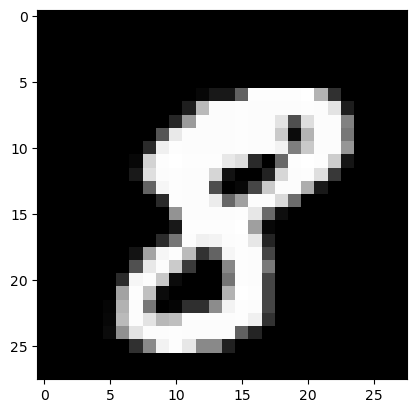

The associated digit is: 8.0


In [4]:
from mpl_toolkits.mplot3d import Axes3D

try:
    data = np.genfromtxt("MNIST.csv", delimiter=",")[1:]
except OSError:
    print("Error: 'MNIST.csv' not found. Please ensure the file is in the correct path.")

print(f"Shape of the data: {data.shape}")

# Split data into a matrix X and a vector Y
Y = data[:, 0]   # The first column is the label
X = data[:, 1:]  # The rest are pixels

print(f"Shape of X: {X.shape}, Shape of Y:{Y.shape}.")

def visualize(X, idx):
    # Visualize the image of index 'idx' from the dataset 'X'
    if idx >= len(X): return
    img = X[idx]
    img = np.reshape(img, (28, 28))
    plt.imshow(img, cmap='gray')
    plt.show()

# Visualize image number 10 and the corresponding digit.
idx = 10
visualize(X, idx)
print(f"The associated digit is: {Y[idx]}")




In [11]:

def split_data(X, Y, N_train):
    N, d = X.shape
    # Sample indices and shuffle them
    idx = np.arange(N)
    np.random.shuffle(idx)
    
    # Extract the set of index 
    train_idx = idx[:N_train]
    test_idx = idx[N_train:]  
    
    X_train = X[train_idx]
    Y_train = Y[train_idx]
    X_test = X[test_idx]
    Y_test = Y[test_idx]

    return (X_train, Y_train), (X_test, Y_test)

def run_custom_pca(X_raw, Y_raw, d1, d2, k=2, plot_3d=False):
    """
    Encapsulates the pipeline to repeat for different digits or k values.
    """
    print(f"\n--- Running PCA for {d1} vs {d2} with k={k} ---")
    
    # 1. Filter
    mask = (Y_raw == d1) | (Y_raw == d2)
    X_sub = X_raw[mask]
    Y_sub = Y_raw[mask]
    
    # 2. Split
    N_tr = int(len(X_sub) * 0.8)
    (X_tr, Y_tr), (X_te, Y_te) = split_data(X_sub, Y_sub, N_tr)
    
    # 3. Center
    mean_vec = np.mean(X_tr, axis=0).reshape(1, -1)
    X_tr_c = X_tr - mean_vec
    X_te_c = X_te - mean_vec
    
    # 4. SVD & Project
    U, s, Vt = np.linalg.svd(X_tr_c, full_matrices=False)
    P_matrix = Vt[:k] # Shape (k, d)
    
    Z_tr = X_tr_c @ P_matrix.T
    Z_te = X_te_c @ P_matrix.T
    
    # 5. Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d') if plot_3d else fig.add_subplot(111)
    
    colors = {d1: 'blue', d2: 'red'}
    
    # Helper to plot specific subset
    def plot_points(Z, Y, dataset_name, marker, alpha, edge=None):
        for digit in [d1, d2]:
            m = Y == digit
            xs = Z[m, 0]
            ys = Z[m, 1]
            zs = Z[m, 2] if plot_3d else None
            
            lbl = f'{dataset_name} {digit}'
            
            if plot_3d:
                ax.scatter(xs, ys, zs, c=colors[digit], marker=marker, 
                           alpha=alpha, edgecolor=edge, label=lbl)
            else:
                ax.scatter(xs, ys, c=colors[digit], marker=marker, 
                           alpha=alpha, edgecolor=edge, label=lbl)

    plot_points(Z_tr, Y_tr, 'Train', 'o', 0.1, None)
    plot_points(Z_te, Y_te, 'Test', '^', 0.9, 'k')
    
    ax.set_title(f"PCA: {d1} vs {d2} (k={k})")
    
    # Clean legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    plt.show()


--- Running PCA for 3 vs 4 with k=2 ---


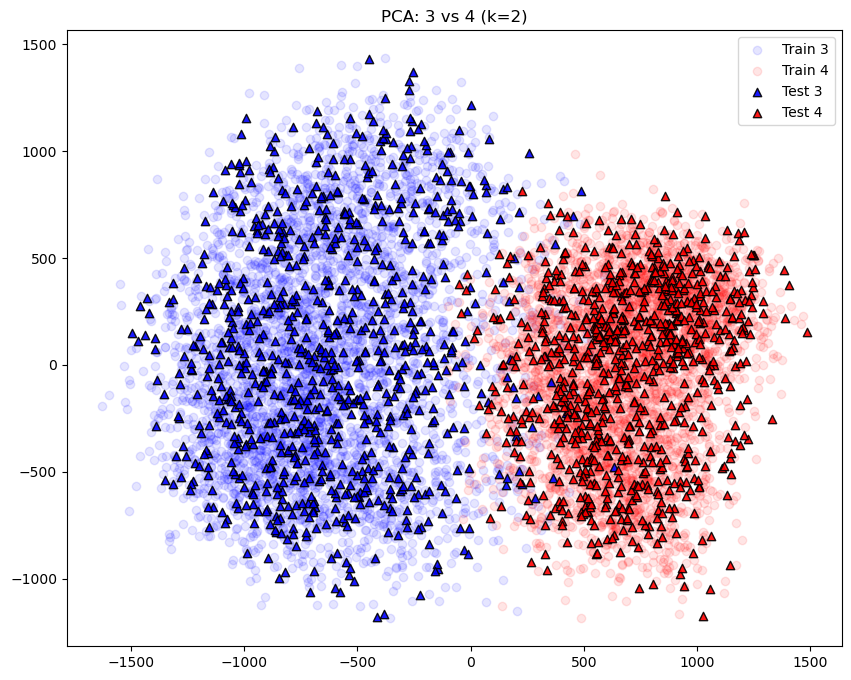


--- Running PCA for 1 vs 7 with k=2 ---


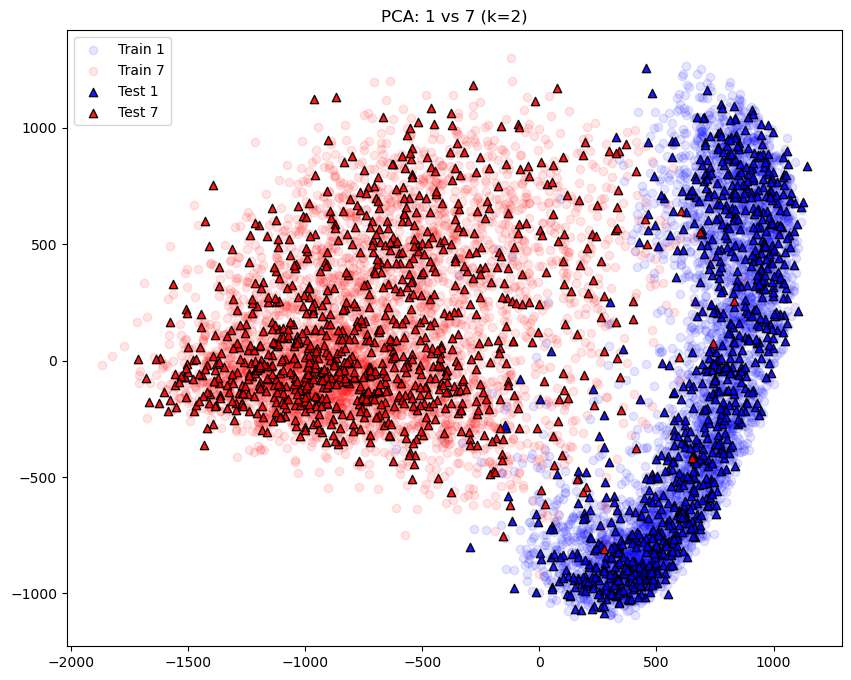


--- Running PCA for 5 vs 8 with k=2 ---


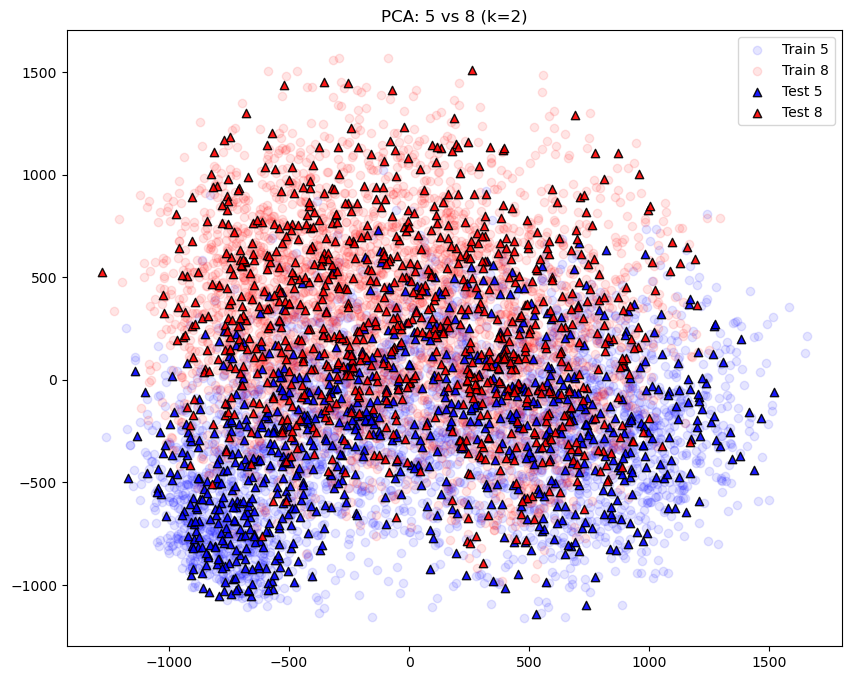


--- Running PCA for 3 vs 4 with k=3 ---


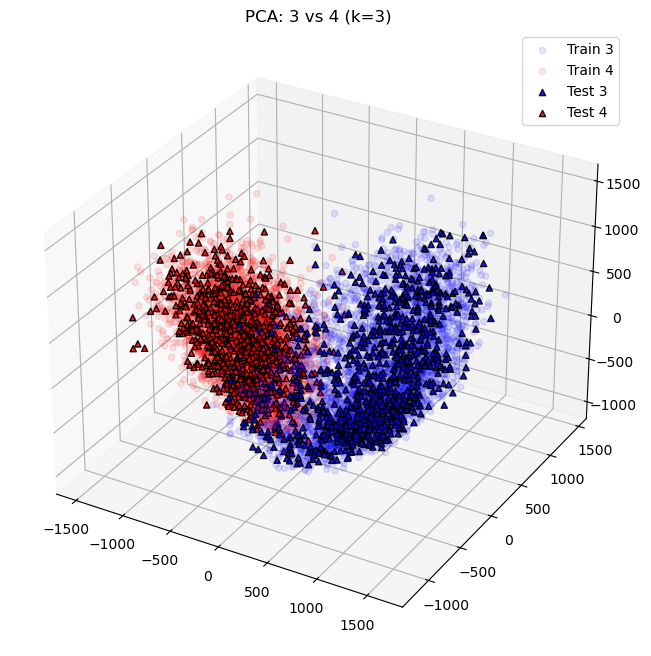

In [12]:
# 3 vs 4 (k=2)
run_custom_pca(X, Y, 3, 4, k=2, plot_3d=False)

# 1 vs 7 (k=2)
run_custom_pca(X, Y, 1, 7, k=2, plot_3d=False)

# 5 vs 8 (k=2)
run_custom_pca(X, Y, 5, 8, k=2, plot_3d=False)

# 3 vs 4 (k=3, 3D Plot)
run_custom_pca(X, Y, 3, 4, k=3, plot_3d=True)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

# ==========================================
# PART 1: Data Loading & PCA Setup
# ==========================================

def load_and_filter_data(d1, d2, filename="data/MNIST.csv"):
    """
    Loads MNIST data, filters for two specific digits, and splits into Train/Test.
    """
    print(f"Loading and filtering for digits {d1} and {d2}...")
    try:
        # Skip header to avoid NaN
        data = np.genfromtxt(filename, delimiter=",", skip_header=1)
    except OSError:
        print(f"Error: {filename} not found. Generating dummy data.")
        data = np.random.rand(500, 785)
        data[:, 0] = np.random.choice([d1, d2], 500)

    # Label is column 0, Pixels are columns 1-784
    Y = data[:, 0]
    X = data[:, 1:]

    # Filter
    mask = (Y == d1) | (Y == d2)
    X_sub = X[mask]
    Y_sub = Y[mask]

    # Split (80/20)
    N = len(X_sub)
    N_train = int(N * 0.8)
    
    # Shuffle
    idx = np.arange(N)
    np.random.shuffle(idx)
    
    X_train = X_sub[idx[:N_train]]
    Y_train = Y_sub[idx[:N_train]]
    X_test = X_sub[idx[N_train:]]
    Y_test = Y_sub[idx[N_train:]]
    
    return (X_train, Y_train), (X_test, Y_test)

def perform_pca_projection(X_train, X_test, k=2):
    """
    Computes PCA on X_train and projects both Train and Test sets.
    """
    # 1. Center the data (compute mean on TRAIN only)
    mean_vec = np.mean(X_train, axis=0)
    X_train_c = X_train - mean_vec
    X_test_c = X_test - mean_vec  # Apply train mean to test
    
    # 2. Compute SVD on Training data
    # U, s, Vt = svd(X)
    U, s, Vt = np.linalg.svd(X_train_c, full_matrices=False)
    
    # 3. Define Projection Matrix P (first k rows of Vt)
    P = Vt[:k] # Shape (k, d)
    
    # 4. Project
    Z_train = X_train_c @ P.T
    Z_test = X_test_c @ P.T
    
    return Z_train, Z_test, P

In [15]:

def run_experiment(d1, d2):
    # 1. Get Data and Project
    (X_tr, Y_tr), (X_te, Y_te) = load_and_filter_data(d1, d2)
    Z_tr, Z_te, P_mat = perform_pca_projection(X_tr, X_te, k=2)
    
    print(f"Data projected to 2D. Train shape: {Z_tr.shape}")

    # --- Classifier A: Linear (Logistic Regression via SGD) ---
    print("\n--- Linear Classifier (SGD) ---")
    # loss='log_loss' enables Logistic Regression
    clf = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)
    clf.fit(Z_tr, Y_tr)
    
    Y_pred_linear = clf.predict(Z_te)
    
    print("Accuracy:", accuracy_score(Y_te, Y_pred_linear))
    print("Confusion Matrix:\n", confusion_matrix(Y_te, Y_pred_linear))
    
    # --- Classifier B: Nearest Centroid ---
    print("\n--- PCA-Centroid Classifier ---")
    # 1. Compute Centroids
    mask_d1 = Y_tr == d1
    mask_d2 = Y_tr == d2
    
    mu_1 = np.mean(Z_tr[mask_d1], axis=0) # Centroid for digit d1
    mu_2 = np.mean(Z_tr[mask_d2], axis=0) # Centroid for digit d2
    
    # 2. Compute Distances for Test Points
    # dist_1 = ||z - mu_1||
    dist_1 = np.linalg.norm(Z_te - mu_1, axis=1)
    dist_2 = np.linalg.norm(Z_te - mu_2, axis=1)
    
    # 3. Assign Class
    # If dist_1 < dist_2, predict d1, else d2
    Y_pred_centroid = np.where(dist_1 < dist_2, d1, d2)
    
    print("Accuracy:", accuracy_score(Y_te, Y_pred_centroid))
    print("Confusion Matrix:\n", confusion_matrix(Y_te, Y_pred_centroid))

    # --- Visualization ---
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # 1. Scatter Plot of Test Data (Correctly Classified)
    # We plot the ground truth, but we will highlight errors
    colors = {d1: 'blue', d2: 'red'}
    for digit in [d1, d2]:
        mask = Y_te == digit
        ax.scatter(Z_te[mask, 0], Z_te[mask, 1], c=colors[digit], label=f'Class {digit}', alpha=0.5, s=20)

    # 2. Highlight Misclassified Points (Linear Model)
    errors = Y_pred_linear != Y_te
    ax.scatter(Z_te[errors, 0], Z_te[errors, 1], facecolors='none', edgecolors='black', s=100, linewidth=1.5, label='Misclassified (Linear)')

    # 3. Plot Linear Decision Boundary
    # w1*x + w2*y + b = 0  =>  y = -(w1*x + b) / w2
    w = clf.coef_[0]
    b = clf.intercept_[0]
    x_min, x_max = Z_te[:, 0].min(), Z_te[:, 0].max()
    x_vals = np.linspace(x_min, x_max, 100)
    y_vals = -(w[0] * x_vals + b) / w[1]
    ax.plot(x_vals, y_vals, 'k--', linewidth=2, label='Linear Boundary')

    # 4. Plot Centroids
    ax.scatter(mu_1[0], mu_1[1], c='cyan', s=200, marker='X', edgecolors='black', label=f'Centroid {d1}')
    ax.scatter(mu_2[0], mu_2[1], c='magenta', s=200, marker='X', edgecolors='black', label=f'Centroid {d2}')
    
    # Connect centroids to visualize the geometric margin
    ax.plot([mu_1[0], mu_2[0]], [mu_1[1], mu_2[1]], 'k:', alpha=0.5)

    ax.set_title(f"Classification Analysis: {d1} vs {d2} (PCA k=2)")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.show()



Loading and filtering for digits 3 and 4...
Error: data/MNIST.csv not found. Generating dummy data.
Data projected to 2D. Train shape: (400, 2)

--- Linear Classifier (SGD) ---
Accuracy: 0.42
Confusion Matrix:
 [[10 48]
 [10 32]]

--- PCA-Centroid Classifier ---
Accuracy: 0.41
Confusion Matrix:
 [[28 30]
 [29 13]]


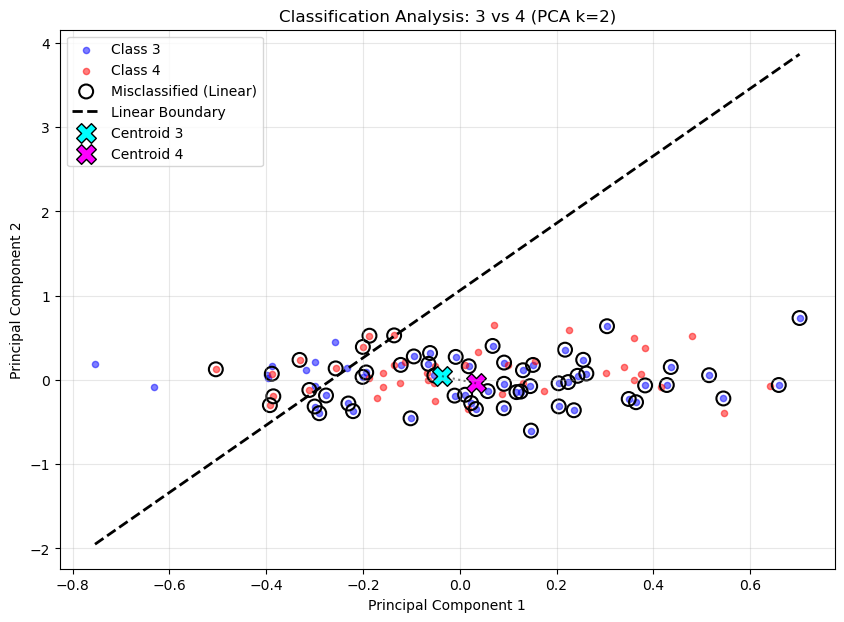

Loading and filtering for digits 1 and 7...
Error: data/MNIST.csv not found. Generating dummy data.
Data projected to 2D. Train shape: (400, 2)

--- Linear Classifier (SGD) ---
Accuracy: 0.51
Confusion Matrix:
 [[10 45]
 [ 4 41]]

--- PCA-Centroid Classifier ---
Accuracy: 0.48
Confusion Matrix:
 [[24 31]
 [21 24]]


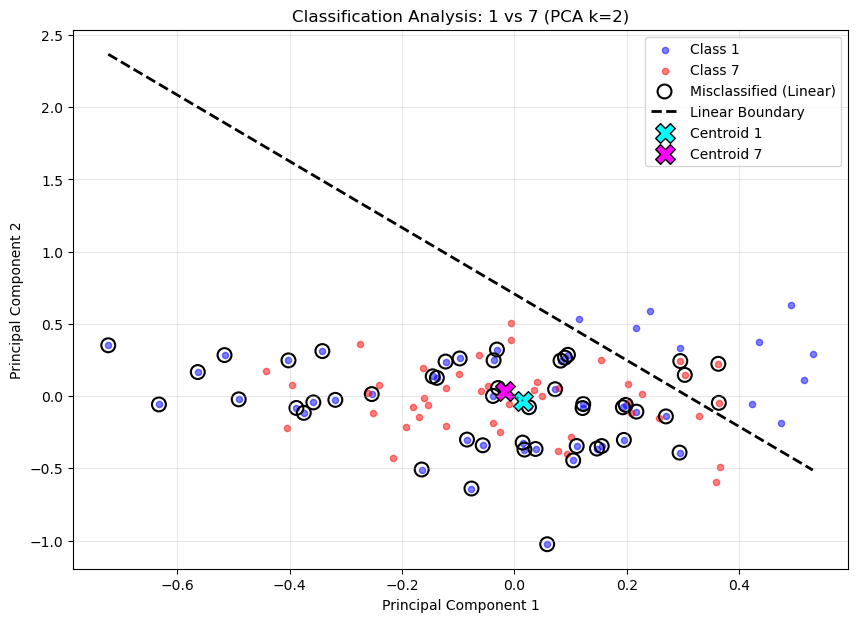

Loading and filtering for digits 5 and 8...
Error: data/MNIST.csv not found. Generating dummy data.
Data projected to 2D. Train shape: (400, 2)

--- Linear Classifier (SGD) ---
Accuracy: 0.54
Confusion Matrix:
 [[13 33]
 [13 41]]

--- PCA-Centroid Classifier ---
Accuracy: 0.46
Confusion Matrix:
 [[22 24]
 [30 24]]


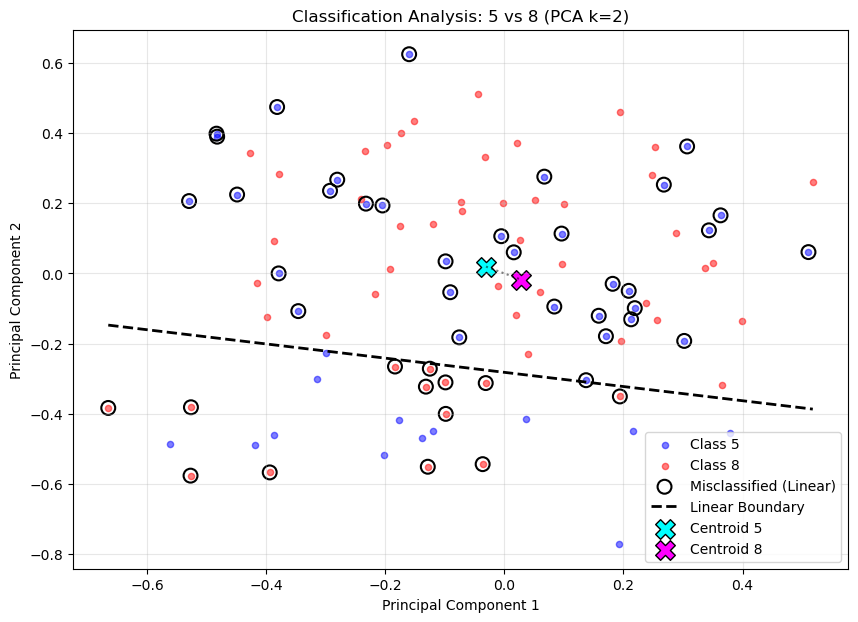

In [16]:

# Case 1: The Standard Example (3 vs 4)
run_experiment(3, 4)

# Case 2: Similar shapes (1 vs 7)
# These often overlap more in 2D space
run_experiment(1, 7)

# Case 3: Curvy shapes (5 vs 8)
run_experiment(5, 8)